In [1]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns

import rasterio
import rioxarray
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
from scipy.interpolate import griddata
from tqdm import tqdm
import datetime 

## LAI: Ratio of a plant's total lead area to its total land area

In [5]:
# Details For Data Processing 
# Check out ./fall_2023/Thesis Data Preprocessing - Lead Area Index [NOAA_LAI].ipynb
LAI_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv')
LAI_df = LAI_df.rename(columns = {'Latitude': 'lat', 'Longitude': 'lon'})

LAI_df.head(2)

,lat,lon,LAI,FAPAR,Year,Month,Day
0,53.425,122.524994,2.731,0.674,2017,6,10
1,53.125,120.774994,3.155,0.725,2017,6,10


In [6]:
SMAP_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017_With_Status.csv')
SMAP_df['time'] = pd.to_datetime(SMAP_df['time'])
SMAP_df.head(2)

,lat,lon,interpolated_precip,moisture,temp,time,sum_precip_14_days,status
0,47.065426,133.646271,0.0,-9999.0,266.7419,2017-01-01,0.0,dry
1,47.065426,124.870331,0.0,-9999.0,264.7993,2017-01-01,0.0,dry


In [7]:
LAI_test = LAI_df[(LAI_df['Year'] == 2017) & (LAI_df['Month'] == 1) & (LAI_df['Day'] == 1)]
SMAP_test = SMAP_df[SMAP_df['time'] == '2017-01-01']

def get_grid_resolution(df, lat_col='lat', lon_col='lon'):
    # Calculate differences in latitudes and longitudes
    lat_diff = np.diff(sorted(df[lat_col].unique()))
    lon_diff = np.diff(sorted(df[lon_col].unique()))

    # Average resolution
    lat_res = np.mean(lat_diff)
    lon_res = np.mean(lon_diff)

    return lat_res, lon_res

# Get grid resolutions for CHIRPS_2017 and SMAP_2017
chirps_res = get_grid_resolution(LAI_test)
smap_res = get_grid_resolution(SMAP_test)

print("NOAA LAI Resolution:", chirps_res)
print("SMAP Resolution:", smap_res)

# Determine which dataset has the larger grid
if chirps_res > smap_res:
    target_grid = 'NOAA LAI'
    finer_grid_df = SMAP_df
else:
    target_grid = 'SMAP'
    finer_grid_df = LAI_df

print("Dataset with larger grid:", target_grid)

NOAA LAI Resolution: (0.05506536274509804, 0.050633454391891895)
SMAP Resolution: (0.08829211718930399, 0.09464578891019208)
Dataset with larger grid: SMAP


### Test

In [8]:
# Step 1: Determine the SMAP Grid Points

lat_points = SMAP_test['lat'].unique()
lon_points = SMAP_test['lon'].unique()

# Create a mesh grid for the target (SMAP) resolution
grid_x, grid_y = np.meshgrid(lon_points, lat_points)

In [9]:
# Step 2: Perform the Interpolation


# Remove rows with NaN values in the precipitation column
LAI_clean = LAI_test.dropna(subset=['LAI'])

# Prepare CHIRPS data for interpolation
points = LAI_clean[['lat', 'lon']].values
values = LAI_clean['LAI'].values

# Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
interpolated_LAI = griddata(points, values, (grid_y, grid_x), method='linear')

# Check the output after interpolation
if not np.any(interpolated_LAI > 0):
    print("Warning: Interpolation resulted in zeros only.")

# Convert the interpolated data back to a DataFrame
interpolated_df = pd.DataFrame({
    'lat': grid_y.ravel(),
    'lon': grid_x.ravel(),
    'interpolated_LAI': interpolated_LAI.ravel()
})


In [10]:
# Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
interpolated_precip = griddata(points, values, (grid_y, grid_x), method='linear')

before_interpolate = sum(LAI_test[LAI_test['LAI'] > 0]['LAI'])
print('total LAI before interpolate: ', before_interpolate)
after_interpolate = sum(interpolated_df[interpolated_df['interpolated_LAI'] > 0]['interpolated_LAI'])
print('total LAI after interpolate: ', after_interpolate)

total LAI before interpolate:  19107.627000000066
total LAI after interpolate:  50502.74885135808


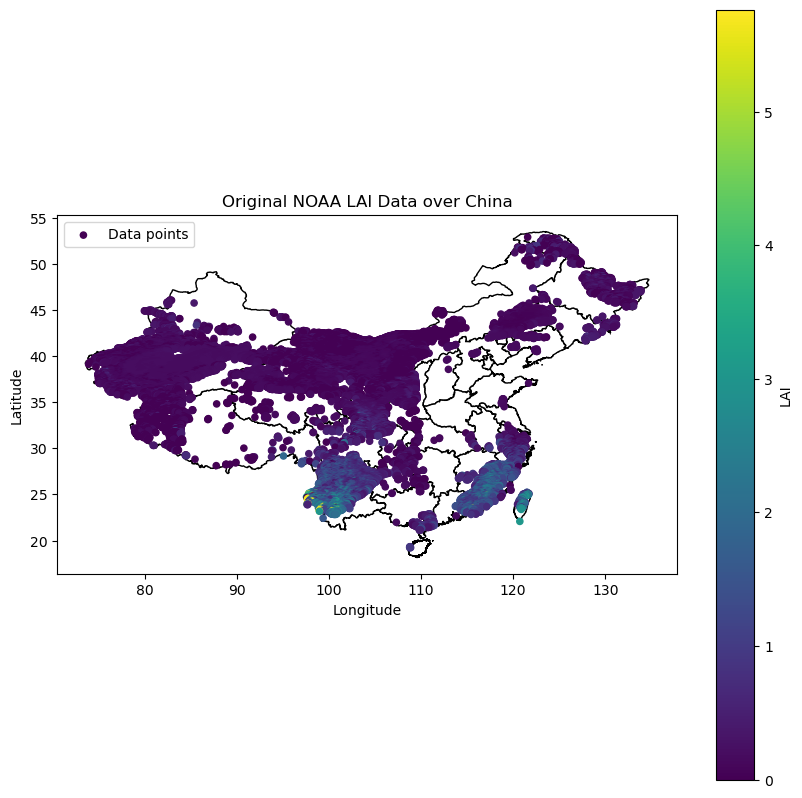

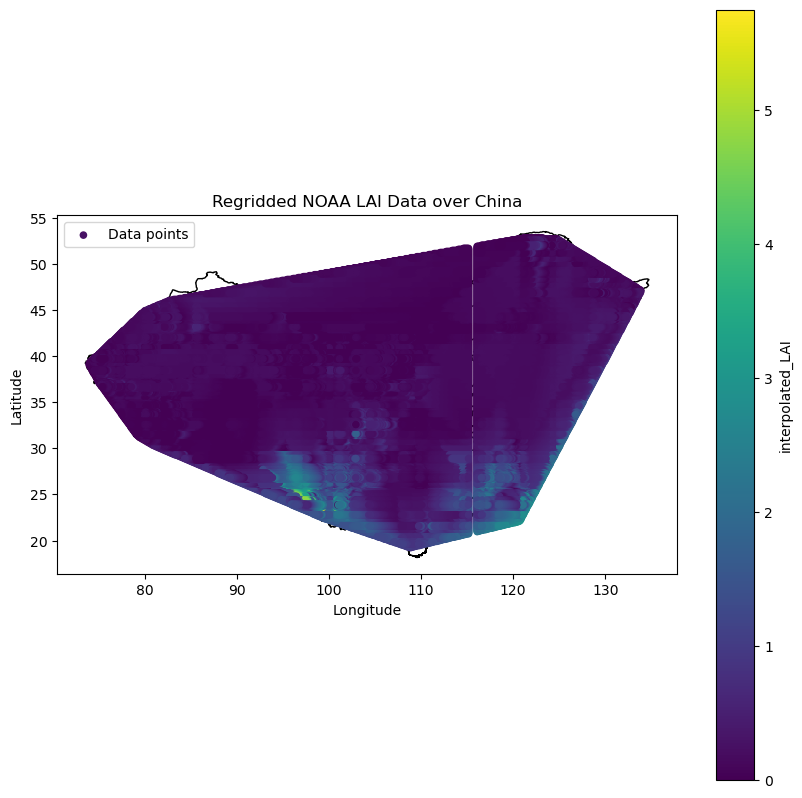

In [11]:
# Validation: Make Sure Re-gridding do not change our data by plotting

def plot_data_with_shapefile(gdf, title, china_map, column):
    fig, ax = plt.subplots(figsize=(10, 10))
    china_map.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, x='lon', y='lat', kind='scatter', c=column, cmap='viridis', label='Data points', colorbar=True)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    
china_shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'  # Update this path
china_map = gpd.read_file(china_shapefile_path)

# Convert CHIRPS_test and interpolated_df to GeoDataFrames
gdf_chirps = gpd.GeoDataFrame(LAI_test, geometry=gpd.points_from_xy(LAI_test.lon, LAI_test.lat))
gdf_interpolated = gpd.GeoDataFrame(interpolated_df, geometry=gpd.points_from_xy(interpolated_df.lon, interpolated_df.lat))

# Plotting
plot_data_with_shapefile(gdf_chirps, 'Original NOAA LAI Data over China', china_map, 'LAI')
plot_data_with_shapefile(gdf_interpolated, 'Regridded NOAA LAI Data over China', china_map, 'interpolated_LAI')


### Regrid LAI to SMAP

In [12]:
def interpolate_LAI_for_day(LAI_day_df, SMAP_day_df):
    # Make sure LAI data is prepared correctly
    if 'LAI' not in LAI_day_df.columns:
        raise KeyError("LAI column not found in LAI_day_df")

    # Drop rows where LAI is NaN and extract the relevant columns
    LAI_clean = LAI_day_df.dropna(subset=['LAI'])
    LAI_clean = LAI_clean.dropna(subset=['FAPAR'])
    points = LAI_clean[['lat', 'lon']].values
    LAI_values = LAI_clean['LAI'].values
    FAPAR_values = LAI_clean['FAPAR'].values

    # Ensure 'points' is in the correct shape
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("Points array is not in the correct shape")

    # Define the target grid based on SMAP data
    lat_points = SMAP_day_df['lat'].unique()
    lon_points = SMAP_day_df['lon'].unique()
    grid_x, grid_y = np.meshgrid(lon_points, lat_points)

    # Ensure the grid is correctly formatted for interpolation
    xi = (grid_y.ravel(), grid_x.ravel())  # Flatten the grid arrays

    # Interpolate using the 'linear' method
    interpolated_LAI = griddata(points, LAI_values, xi, method='linear')
    interpolated_FAPAR = griddata(points, FAPAR_values, xi, method='linear')

    # Convert the interpolated data back to DataFrame
    interpolated_df = pd.DataFrame({
        'lat': grid_y.ravel(),
        'lon': grid_x.ravel(),
        'interpolated_LAI': interpolated_LAI,
        'interpolated_FAPAR': interpolated_FAPAR,
    })

    return interpolated_df


In [14]:
def interpolate_LAI_for_day(LAI_test, grid_x, grid_y):
    
    # Remove rows with NaN values in the precipitation column
    LAI_clean = LAI_test.dropna(subset=['LAI'])
    LAI_clean = LAI_clean.dropna(subset=['FAPAR'])

    # Prepare CHIRPS data for interpolation
    points = LAI_clean[['lat', 'lon']].values
    LAI_values = LAI_clean['LAI'].values
    FAPAR_values = LAI_clean['FAPAR'].values

    # Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
    interpolated_LAI = griddata(points, LAI_values, (grid_y, grid_x), method='linear')
    interpolated_FAPAR = griddata(points, FAPAR_values, (grid_y, grid_x), method='linear')

    # Check the output after interpolation
    if not np.any(interpolated_LAI > 0):
        print("Warning: Interpolation resulted in zeros only.")

    # Convert the interpolated data back to a DataFrame
    interpolated_df = pd.DataFrame({
        'lat': grid_y.ravel(),
        'lon': grid_x.ravel(),
        'interpolated_LAI': interpolated_LAI.ravel(),
        'interpolated_FAPAR': interpolated_FAPAR.ravel()
    })
    
    return interpolated_df


In [34]:
import tqdm
import datetime 

def regrid_LAI_to_SMAP(LAI_df, SMAP_df):
    
    SMAP_test = SMAP_df[SMAP_df['time'] == SMAP_df['time'][0]]
    # Step 1: Determine the SMAP Grid Points
    lat_points = SMAP_test['lat'].unique()
    lon_points = SMAP_test['lon'].unique()
    
    # Create a mesh grid for the target (SMAP) resolution
    grid_x, grid_y = np.meshgrid(lon_points, lat_points)

    # Apply the function to interpolate the entire LAI_df for all times
    all_interpolated_data = pd.DataFrame()

    # Loop through each unique date in LAI_df with progress tracking
    unique_dates = LAI_df[['Year', 'Month', 'Day']].drop_duplicates()
    time = []
    for _, row in tqdm.tqdm(unique_dates.iterrows(), total=unique_dates.shape[0], desc="Interpolating LAI Data"):
        date = datetime.datetime(row['Year'], row['Month'], row['Day'])
        LAI_test = LAI_df[(LAI_df['Year'] == row['Year']) & (LAI_df['Month'] == row['Month']) & (LAI_df['Day'] == row['Day'])]
        
        try:
            # Perform interpolation for each unique date
            interpolated_day_df = interpolate_LAI_for_day(LAI_test, grid_x, grid_y)
            all_interpolated_data = pd.concat([all_interpolated_data, interpolated_day_df])
            time += [date] * interpolated_day_df.shape[0]
        except:
            print('error with day ', date)

    all_interpolated_data['time'] = time
    return all_interpolated_data.dropna().reset_index()


In [30]:
# test_df = regrid_LAI_to_SMAP(LAI_df, SMAP_df)
# test_df

# merged_df = pd.merge(SMAP_df, test_df, on=['lat', 'lon', 'time'], how='left')
# merged_df = merged_df[['lat','lon','interpolated_precip','temp','time','status', 'interpolated_LAI']]

# merged_df[merged_df['interpolated_LAI'] > 0 ]

In [31]:
LAI_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv')
LAI_df = LAI_df.rename(columns = {'Latitude': 'lat', 'Longitude': 'lon'})

SMAP_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017_With_Status.csv')
SMAP_df['time'] = pd.to_datetime(SMAP_df['time'])

regridded_LAI = regrid_LAI_to_SMAP(LAI_df, SMAP_df)

regridded_LAI.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/Regridded_LAI_to_SMAP_Year_2017.csv', index = False, header = True)

Interpolating LAI Data: 100%|██████████| 358/358 [17:20<00:00,  2.91s/it]


In [32]:
LAI_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2018.csv')
LAI_df = LAI_df.rename(columns = {'Latitude': 'lat', 'Longitude': 'lon'})

SMAP_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2018_With_Status.csv')
SMAP_df['time'] = pd.to_datetime(SMAP_df['time'])

regridded_LAI = regrid_LAI_to_SMAP(LAI_df, SMAP_df)

regridded_LAI.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/Regridded_LAI_to_SMAP_Year_2018.csv', index = False, header = True)

Interpolating LAI Data: 100%|██████████| 365/365 [15:18<00:00,  2.52s/it]


In [35]:
LAI_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv')
LAI_df = LAI_df.rename(columns = {'Latitude': 'lat', 'Longitude': 'lon'})

SMAP_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2019_With_Status.csv')
SMAP_df['time'] = pd.to_datetime(SMAP_df['time'])

regridded_LAI = regrid_LAI_to_SMAP(LAI_df, SMAP_df)

regridded_LAI.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/Regridded_LAI_to_SMAP_Year_2019.csv', index = False, header = True)

Interpolating LAI Data:   8%|▊         | 31/365 [00:40<08:00,  1.44s/it]

error with day  2019-11-30 00:00:00


Interpolating LAI Data: 100%|██████████| 365/365 [12:08<00:00,  2.00s/it]


In [13]:
regridded_LAI = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/Regridded_LAI_to_SMAP_Year_2017.csv')
# regridded_LAI = regridded_LAI[['lat', 'lon', 'interpolated_LAI']].dropna()
regridded_LAI

,index,lat,lon,interpolated_LAI,time
0,0,47.065426,133.646271,1.182246,2017-06-10
1,1,47.065426,124.870331,0.870051,2017-06-10
2,2,47.065426,124.776970,0.882825,2017-06-10
3,3,47.065426,124.683609,0.895600,2017-06-10
4,4,47.065426,124.590248,0.908374,2017-06-10
...,...,...,...,...,...
53211666,266576,23.862606,116.374481,0.854464,2017-02-19
53211667,266577,23.862606,116.281120,0.859873,2017-02-19
53211668,266578,23.862606,116.187759,0.865282,2017-02-19
53211669,266579,23.862606,116.094398,0.870691,2017-02-19


In [3]:
SMAP_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017_With_Status.csv')
SMAP_df = SMAP_df[['lat', 'lon', 'interpolated_precip', 'temp', 'time', 'status']]
SMAP_df.head(2)

,lat,lon,interpolated_precip,moisture,temp,time,sum_precip_14_days,status
0,47.065426,133.646271,0.0,-9999.0,266.7419,2017-01-01,0.0,dry
1,47.065426,124.870331,0.0,-9999.0,264.7993,2017-01-01,0.0,dry


In [ ]:
merged_df = pd.merge(SMAP_df, regridded_LAI, on=['lat', 'lon'], how='left')
merged_df = merged_df[['lat','lon','interpolated_precip','temp','time','status', 'interpolated_LAI']]

merged_df.head(2)